<a href="https://colab.research.google.com/github/BSV22/ReinforceGT_Stamatics/blob/master/ReinforceGT_Tech_Hunters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎯 Project Setup: Option Pricing & Game Theory

### This project combines **Binomial Tree Option Pricing** with **Game Theory (Nash Equilibrium)** to explore strategic financial decision-making.


##  Importing Libraries

To get started, we’ll import the essential Python libraries needed for this project.

### 🔧 Required Libraries

1. **`yfinance`**  – For downloading stock and option data  
2. **`numpy`**  – For numerical operations and array handling  
3. **`pandas`**  – For working with structured data and time series  
4. **`scipy.optimize.linprog`**  – For solving linear programming problems in game theory  
5. **`matplotlib.pyplot`**  – For visualizing price paths, option values, and game matrices



# Library Imports
```
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt
```


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

##  Initialization of Parameters

### These variables will be used frequently, so we define them at the beginning for easy reference.

---

###  Parameter List:

1. `ticker = "AAPL"` – Stock symbol for Apple Inc.  
2. `start_date = "2022-01-01"` – Start date for historical data.  
3. `end_date = "2023-01-01"` – End date for historical data.  
4. `steps = 100` – Number of steps in the binomial tree.  
5. `r = 0.06` – Annual risk-free interest rate (6%).

---

###  Usage:

- **`ticker`, `start_date`, `end_date`** → For downloading stock and option data.  
- **`steps`, `r`** → For building the binomial tree and discounting option values.


In [ ]:
# Initial Parameter
ticker = "AAPL"
start_date = "2022-01-01"
end_date = "2023-01-01"
steps = 100
r = 0.06

call = True

##  Defining Function for Fetching Data from Yahoo Finance

### This function retrieves the following data:

1. **Historical Stock Prices** – Includes Open, High, Low, Close, and Volume for each date.  
2. **Option Chain Data** – Contains available **Call and Put options** with details such as strike prices, expiration dates, and premiums.




In [ ]:
def fetch_data(ticker, start_date, end_date):
    """Fetch stock and option data from Yahoo Finance"""
    stock = yf.Ticker(ticker)
    stock_prices = stock.history(start=start_date, end=end_date)['Close']

    # Get options data (nearest expiration)
    options_dates = stock.options
    if not options_dates:
        raise ValueError("No options data available for the given ticker")

    option_chain = stock.option_chain(options_dates[0])
    calls = option_chain.calls
    puts = option_chain.puts

    return stock_prices, calls, puts

prices, calls, puts = fetch_data(ticker, start_date, end_date)
calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250725C00110000,2025-07-17 19:37:42+00:00,110.0,101.07,0.0,0.0,0.0,0.0,27.0,0,0.00001,True,REGULAR,USD
1,AAPL250725C00120000,2025-06-27 17:42:44+00:00,120.0,81.97,0.0,0.0,0.0,0.0,5.0,0,0.00001,True,REGULAR,USD
2,AAPL250725C00125000,2025-07-17 14:34:08+00:00,125.0,85.20,0.0,0.0,0.0,0.0,10.0,0,0.00001,True,REGULAR,USD
3,AAPL250725C00135000,2025-06-23 17:28:40+00:00,135.0,67.00,0.0,0.0,0.0,0.0,2.0,0,0.00001,True,REGULAR,USD
4,AAPL250725C00140000,2025-07-18 14:13:48+00:00,140.0,70.15,0.0,0.0,0.0,0.0,1.0,0,0.00001,True,REGULAR,USD


In [ ]:
prices

,Close
Date,
2022-01-03 00:00:00-05:00,178.645645
2022-01-04 00:00:00-05:00,176.378326
2022-01-05 00:00:00-05:00,171.686707
2022-01-06 00:00:00-05:00,168.820694
2022-01-07 00:00:00-05:00,168.987534
...,...
2022-12-23 00:00:00-05:00,130.173798
2022-12-27 00:00:00-05:00,128.367203
2022-12-28 00:00:00-05:00,124.428207


## 📐 Formulas Used

---

### 1. Log Return

The daily **logarithmic return** is calculated as:

$$
r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

Where:


$$
P_t = \text{Price of the stock at time } t
$$

$$
P_{t-1} = \text{Price of the stock at time } t - 1
$$

$$
r_t = \text{Log return at time } t
$$

---

### 2. Annualized Volatility

Volatility is computed as the **standard deviation of daily log returns**, annualized using the square root of 252 (approximate number of trading days in a year):

$$
\sigma = \text{std}(r_t) \times \sqrt{252}
$$

Where:
$$
\text{std}(r_t) = \text{Standard deviation of the daily log returns}
$$

$$
\sigma = \text{Annualized volatility}
$$




In [ ]:
def calculate_volatility(prices):

    log_returns = np.log(prices / prices.shift(1)).dropna()
    return log_returns.std() * np.sqrt(252)

sigma= calculate_volatility(prices)
sigma

np.float64(0.35610511699108677)

# Construction of Binomial Tree
---
###  This is popularly used in the context of option

This is one of the main methods we used here to construct this model  
As the Name suggests, it splits into two from each node  
Starting from a node that contains an initial Price, there are two possibilities that it may go up or down, with up factor and down factor, respectively

In [ ]:
def binomial_tree(S0, K, T, steps, r, sigma):

    dt = T/steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d)/(u - d)

    # Implementation
    price_tree = np.zeros((steps+1, steps+1))
    for i in range(steps+1):
        for j in range(i+1):
            price_tree[j, i] = S0 * (u**(i-j)) * (d**j)

    return price_tree, p, u, d

# derived Parameters
T=1
steps = 100
S0=prices.iloc[0]
K=S0

tree, p, u, d  = binomial_tree(S0, K, T, steps, r, sigma)
pd.DataFrame(tree)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,178.645645,185.121936,191.833006,198.787366,205.993838,213.461559,221.200002,229.218980,237.528663,246.139590,...,4564.027664,4729.483524,4900.937517,5078.607087,5262.717562,5453.502440,5651.203682,5856.072021,6068.367279,6288.358700
1,0.000000,172.395921,178.645645,185.121936,191.833006,198.787366,205.993838,213.461559,221.200002,229.218980,...,4250.278329,4404.360098,4564.027664,4729.483524,4900.937517,5078.607087,5262.717562,5453.502440,5651.203682,5856.072021
2,0.000000,0.000000,166.364836,172.395921,178.645645,185.121936,191.833006,198.787366,205.993838,213.461559,...,3958.097365,4101.586944,4250.278329,4404.360098,4564.027664,4729.483524,4900.937517,5078.607087,5262.717562,5453.502440
3,0.000000,0.000000,0.000000,160.544742,166.364836,172.395921,178.645645,185.121936,191.833006,198.787366,...,3686.002078,3819.627615,3958.097365,4101.586944,4250.278329,4404.360098,4564.027664,4729.483524,4900.937517,5078.607087
4,0.000000,0.000000,0.000000,0.000000,154.928258,160.544742,166.364836,172.395921,178.645645,185.121936,...,3432.611699,3557.051287,3686.002078,3819.627615,3958.097365,4101.586944,4250.278329,4404.360098,4564.027664,4729.483524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.852068,6.064218,6.284059,6.511870,6.747939
97,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.647340,5.852068,6.064218,6.284059
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.449774,5.647340,5.852068
99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.259119,5.449774


# Construction of Payoff Matrix
---
### At Every Node, Option Holder has two strategies: either he may hold the option or execute it

$$ \text{Payoff}_i,_j = \max(S_i,_j - K, 0) $$

 For a Call option, if the Option holder exercises, payoff = Current stock Price - Strike Price  
 If he holds, then payoff = 0

$$ \text{Payoff}_i,_j = \max(K - S_i,_j , 0) $$

 For a Put option if the Option holder executhes , payoff = Strike Price - Current stock Price  
 if he Holds Then payoff = 0

In [ ]:
call = False
def payoff_matrix(price_tree, K):
    steps = price_tree.shape[1] - 1
    for i in range(steps+1):
        for j in range(i+1):
            price_tree[j, i] = max(K-price_tree[j, i], 0)
    return np.maximum(price_tree, 0)

payoff_mat = payoff_matrix(tree, K)
pd.DataFrame(payoff_matrix(tree, K))


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,...,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645
1,0.000000,172.395921,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,...,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645
2,0.000000,0.000000,166.364836,172.395921,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,...,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645
3,0.000000,0.000000,0.000000,160.544742,166.364836,172.395921,178.645645,178.645645,178.645645,178.645645,...,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645
4,0.000000,0.000000,0.000000,0.000000,154.928258,160.544742,166.364836,172.395921,178.645645,178.645645,...,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645,178.645645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.852068,6.064218,6.284059,6.511870,6.747939
97,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.647340,5.852068,6.064218,6.284059
98,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.449774,5.647340,5.852068
99,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.259119,5.449774


#  Calculation of Nash Equilibrium
---

### This is the **Game Theory** component implemented in the model.  
It represents the **second core method** used to construct the option pricing framework.

---

This part is calculated using **Linear Programming**, where we evaluate strategic decisions between **holding** and **executing** the option.

- **`execute_prob`**: Probability of **executing** the option contract  
- **`1 - execute_prob`**: Probability of **holding** the option contract

These probabilities are derived by solving a **zero-sum game** between the holder and the writer of the option, using the `linprog` function from `scipy.optimize`.


In [ ]:
def calculate_nash_equilibrium(payoff_matrix):

    n = payoff_matrix.shape[0]

    # variables for Linear programming
    c = np.ones(n)  # Minimize sum(x)
    A_ub = -payoff_matrix.T  # Constraints: payoff.T * x ≤ 0
    b_ub = np.zeros(n)
    A_eq = np.ones((1, n))  # Condition for probability
    b_eq = np.ones(1)
    bounds = [(0, None)] * n

    # Solveing LP
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)

    if not res.success:
        raise ValueError("Failed To Solve")

    strategy = res.x
    strategy = np.maximum(strategy, 0)  # Ensure non-negative
    strategy /= strategy.sum()  # Normalize

    positive_payoffs = payoff_matrix[payoff_matrix > 0]
    if len(positive_payoffs) > 0:
        execute_prob = np.mean(positive_payoffs) / np.max(positive_payoffs)
    else:
        execute_prob = 0

    # Ensure probabilities are valid
    execute_prob = np.clip(execute_prob, 0, 1)
    hold_prob = 1 - execute_prob

    return np.array([hold_prob, execute_prob])

strategy=calculate_nash_equilibrium(payoff_mat)

pd.DataFrame(calculate_nash_equilibrium(payoff_mat))

,0
0,0.392346
1,0.607654


#  Defining Function for Back-Testing
---

### Back-testing is used to evaluate the accuracy of the model on historical data.

---

This is a **crucial step** in building any financial model.  
It helps us assess how well the model performs under real historical conditions.

By applying the model to past data, we can observe:

- How the model behaves at each node in the binomial tree  
- How the previously calculated probabilities (e.g., `execute_prob`) influence decisions  
- The **profit or loss** the strategy would have generated

This step provides confidence in the model’s reliability before using it for real-world trading or forecasting.


In [ ]:
def backtest_strategy(stock_prices, K, nash_strategy):

    results = []
    for date, price in stock_prices.items():
        # For creating Some Noise
        perturbed_strategy = nash_strategy + np.random.normal(0, 0.01, size=2)
        perturbed_strategy = np.clip(perturbed_strategy, 0, 1)  # Ensure valid probs
        perturbed_strategy /= perturbed_strategy.sum()  # Renormalize

        # We will not use perturbed_strategy (with Noise)

        action = np.random.choice(["Hold", "Execute"], p=nash_strategy)


        profit = (np.maximum(price - K, 0) if call else  np.maximum(K-price, 0))  if action == "Execute" else 0
        results.append({
            "Date": date,
            "Stock_Price": price,
            "Action": action,
            "Profit": profit
        })
    return pd.DataFrame(results)

df = backtest_strategy(prices, K, strategy)
df


,Date,Stock_Price,Action,Profit
0,2022-01-03 00:00:00-05:00,178.645645,Hold,0.000000
1,2022-01-04 00:00:00-05:00,176.378326,Execute,2.267319
2,2022-01-05 00:00:00-05:00,171.686707,Execute,6.958939
3,2022-01-06 00:00:00-05:00,168.820694,Execute,9.824951
4,2022-01-07 00:00:00-05:00,168.987534,Execute,9.658112
...,...,...,...,...
246,2022-12-23 00:00:00-05:00,130.173798,Hold,0.000000
247,2022-12-27 00:00:00-05:00,128.367203,Execute,50.278442
248,2022-12-28 00:00:00-05:00,124.428207,Execute,54.217438
249,2022-12-29 00:00:00-05:00,127.952568,Execute,50.693077


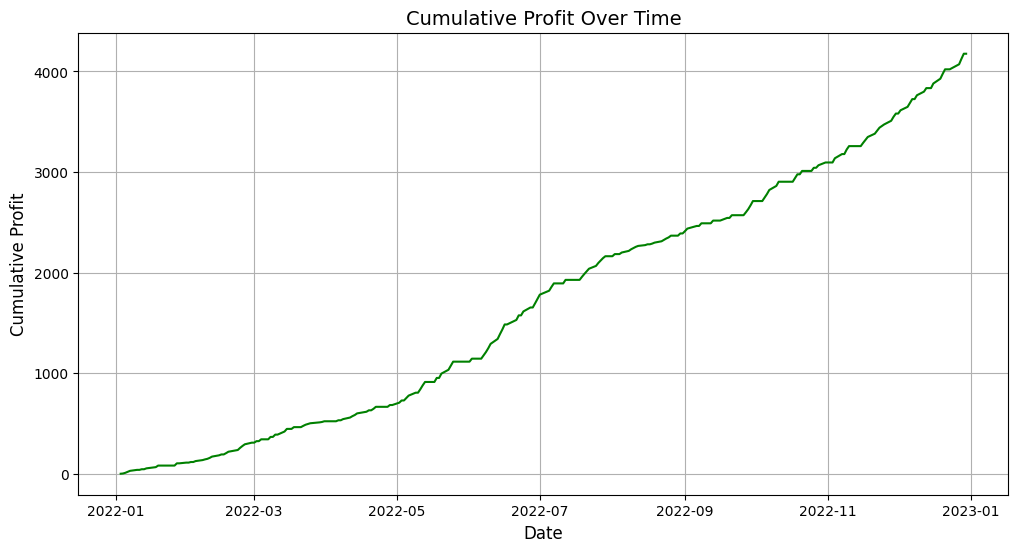

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'Date' column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Calculate cumulative profit
df['Cumulative_Profit'] = df['Profit'].cumsum()

# Plot cumulative profit over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Cumulative_Profit'], linestyle='-', color='green')

# Labels and title
plt.title('Cumulative Profit Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Profit', fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


#  Sensitivity Analysis of Parameters
---

### Sensitivity analysis is performed to understand how changes in input parameters affect the model's behavior—particularly the **average payoff**.

---

This analysis helps answer questions like:

- How sensitive is the model to changes in the **risk-free rate** (r)?
- What happens to the **option value** when the **number of steps** in the binomial tree changes?
- How do changes in **volatility** or **strike price** impact the payoff?

By systematically varying one parameter at a time and observing the outcomes, we can:

- Identify which parameters have the **greatest influence**  
- Test the model's **robustness**  
- Fine-tune the model for **better performance**


In [ ]:
def sensitivity_analysis(base_params, variations):

    results = []
    for param, values in variations.items():
        for value in values:
            params = base_params.copy()
            params[param] = value

            # Rebuild model
            tree, p, u, d = binomial_tree(**params)
            payoff = payoff_matrix(tree, params['K'])

            try:
                nash_strategy = calculate_nash_equilibrium(payoff)
                results.append({
                    "Parameter": param,
                    "Value": value,
                    "Nash_Strategy": nash_strategy,
                    "Avg_Payoff": np.mean(payoff)
                })
            except ValueError:
                continue

    return pd.DataFrame(results)


# 📈 Results
---

### BackTest Results Showing Total Profit

---

These backtesting results are generated on historical data and change every time we run the cell.  

The result changes because the model either **executes** or **holds** the option contract based on probabilities.  

It is not fixed where to execute (at which node), so the model may execute or hold the contract anywhere — but always according to the calculated probability.


In [ ]:
# Backtest
backtest_results = backtest_strategy(prices, K, strategy)
print(f"Total Profit: ${backtest_results['Profit'].sum():.2f}")

Total Profit: $4054.57


In [ ]:
# Sensitivity analysis
base_params = {
    "S0": S0,
    "K": K,
    "T": 1,
    "steps": steps,
    "r": r,
    "sigma": sigma
}

variations = {
    "sigma": [0.2, sigma, 0.3],  # Test volatility
    "steps": [50, 100, 200],         # Test tree granularity
    "r": [0.04, 0.06, 0.08]         # Test interest rates
}

sensitivity_results = sensitivity_analysis(base_params, variations)
pd.DataFrame(sensitivity_results)

,Parameter,Value,Nash_Strategy,Avg_Payoff
0,sigma,0.200000,"[0.49035361506072583, 0.5096463849392742]",19.679160
1,sigma,0.356105,"[0.392345862994972, 0.607654137005028]",26.861410
2,sigma,0.300000,"[0.41693933944186135, 0.5830606605581387]",24.741416
3,steps,50.000000,"[0.4586655402644637, 0.5413344597355363]",22.937002
4,steps,100.000000,"[0.392345862994972, 0.607654137005028]",26.861410
5,steps,200.000000,"[0.30909740395990015, 0.6909025960400998]",30.655385
6,r,0.040000,"[0.392345862994972, 0.607654137005028]",26.861410
7,r,0.060000,"[0.392345862994972, 0.607654137005028]",26.861410
8,r,0.080000,"[0.392345862994972, 0.607654137005028]",26.861410


#  Sensitivity Results
---

### As we can see from the above results in tabular form, it clearly indicates:

---

1. As the **sigma (volatility)** increases, the **average payoff** also increases.  
2. As the **number of steps** increases, the **average payoff** also increases.  
3. There is **no significant change** in average payoffs as the **risk-free rate (r)** changes.


# References & Acknowledgements
---

### 📖 References:

1. Application of Game Theory in Option Pricing: A Binomial Tree
Model Approach : https://www.scitepress.org/Papers/2024/130096/130096.pdf
2. Documentation for:  
   - `yfinance`: https://pypi.org/project/yfinance/  
   - `scipy.optimize.linprog`: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html  
   - `matplotlib`, `numpy`, `pandas`: official Python docs

---

### 👨‍🏫 Mentors:

Under the guidance of:

- **Aayushman Kumar**
- **Hardik Tiwari**
- **Ikrima Badr**
- **Jeevesh Narayan**
- **Piyush Kumar**